In [1]:
from collections import defaultdict
from datetime import datetime
import math
from operator import itemgetter
import os
import random
import re

import numpy as np
import pandas as pd

%matplotlib inline

import little_mallet_wrapper as lmw

<br><br>

# MALLET Path

Change the path below to the location of your local MALLET installation.

In [2]:
MALLET_PATH = '/Users/mah343/Documents/packages/mallet-2.0.8/bin/mallet'  # CHANGE THIS TO YOUR MALLET PATH

<br><br>

# Load poetry dataset

Data is available here: https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset

In [3]:
poetry_path = '/Volumes/Maria\'s Black Passport/data/kaggle-poem-dataset/kaggle_poem_dataset.csv'  # CHANGE THIS TO YOUR DATASET PATH

In [4]:
# 'https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset/download'

In [5]:
poetry_df = pd.read_csv(poetry_path)

poetry_df.sample(10)

,Unnamed: 0,Author,Title,Poetry Foundation ID,Content
13608,13608,William Wordsworth,Three Years She Grew,45559,"Three years she grew in sun and shower,\nThen ..."
3506,3506,David Baker,Dust to Dust,46509,1.\n\nFootfalls on the brickwork road many fat...
9117,9117,Lorna Dee Cervantes,Night Magic (Blue Jester),58859,"Night Magic (Blue Jester), 1988, by Carlos Alm..."
8685,8685,Craig Arnold,Mulberry,56463,You have towered here\nleaning half over the w...
15173,15173,Denis Johnson,Why I Might Go to the Next Football Game,48125,sometimes you know\nthings: once at a\nbirthda...
3894,3894,Carolyn Kizer,The Erotic Philosophers,42604,It’s a spring morning; sun pours in the window...
5545,5545,Melvin Dixon,Heartbeats,146841,Work out. Ten laps.\nChin ups. Look good.\n\nS...
535,535,Andrew Allport,And on the Third Day,55567,"We called off the search,\nand the weary climb..."
12987,12987,Leonard Gontarek,Study/Trees,49227,"Leaves flare up, kitchen matches\nin the perma..."
1615,1615,John Ashbery,[A blue anchor grains of grit in a tall sky se...,146779,A blue anchor grains of grit in a tall sky sew...


In [6]:
print(len(poetry_df.index))

15652


In [7]:
print(len(poetry_df.loc[poetry_df['Author'] == 'Robert Browning'].index))

39


In [8]:
print(len(poetry_df.loc[poetry_df['Author'] == 'William Butler Yeats'].index))

47


In [9]:
print(len(poetry_df.loc[poetry_df['Author'] == 'John Keats'].index))

32


In [10]:
print(len(poetry_df.loc[poetry_df['Author'] == 'Emily Dickinson'].index))

57


In [11]:
print(len(poetry_df.loc[poetry_df['Author'] == 'Christina Rossetti'].index))

30


In [12]:
training_documents = [lmw.process_string(_text) for _text in poetry_df['Content'].tolist()]

len(training_documents)

15652

In [13]:
training_documents[100]

'year twelve daughters turn gone measured pace tho varying mien twelve froward sedater adorn festival reckless attire snow left mountain top fresh flowers withered meadow fig prune hung wrinkling last apple glow amid freckled leaves weary oxen blinkt trodden corn twisted vine whose bunches stood empty crate creak ere long beneath carried home season twelve months gentle hamadryad true love thy mansion thy dim mansion wood blasted laid desolate none dared violate precincts none dared pluck moss beneath alone remain thine old thallinos sat mute solitary sadness strange tale rhaicos died whole echion related force could ever make look back upon oaks father said echion thou must weigh carefully steady hand enough although longer comes store wax burn day night upon hollow stone milk honey lie may gods may dead pleas thallinos bore thither morn lighted left first visited upon solemn day hamadryad oak rhodope acon one age one hope one trust graceful nymph whose fate sorrowed slender pale firs

In [14]:
authors = poetry_df['Author'].tolist()

len(authors)

15652

<br><br>

# Train topic model

Depending on the size of your dataset, training can take a while. For very large datasets, I recommending training outside of a notebook.

While training, you can observe progress by checking the terminal window from which you started Jupyter.

In [15]:
num_topics = 20

In [16]:
output_directory_path = '/Users/mah343/Desktop/lmw-output' # CHANGE THIS TO YOUR OUTPUT DIRECTORY

training_data_path           = output_directory_path + '/training.txt'
formatted_training_data_path = output_directory_path + '/mallet.training'
model_path                   = output_directory_path + '/mallet.model.' + str(num_topics)
topic_keys_path              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
topic_distributions_path     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)

In [17]:
lmw.train_topic_model(MALLET_PATH,
                      training_data_path,
                      formatted_training_data_path,
                      model_path,
                      topic_keys_path,
                      topic_distributions_path,
                      training_documents,
                      num_topics)

Importing data...
Training topic model...


<br><br>

# Load the topics

In [18]:
topics = lmw.load_topic_keys(output_directory_path + '/mallet.topic_keys.20')

for i, t in enumerate(topics):
    print(i, '\t', t)

0 	 ['like', 'man', 'body', 'eyes', 'mother', 'face', 'woman', 'child', 'hands', 'mouth', 'blood', 'hair', 'head', 'dead', 'heart', 'hand', 'night', 'death', 'love', 'father']
1 	 ['num', 'way', 'john', 'name', 'new', 'english', 'used', 'numth', 'also', 'gives', 'line', 'san', 'made', 'right', 'names', 'london', 'jack', 'white', 'left', 'take']
2 	 ['old', 'back', 'dog', 'like', 'little', 'man', 'horse', 'one', 'two', 'head', 'blood', 'mud', 'dogs', 'come', 'black', 'round', 'half', 'tail', 'feet', 'run']
3 	 ['one', 'back', 'room', 'like', 'night', 'door', 'house', 'window', 'street', 'light', 'morning', 'day', 'time', 'still', 'across', 'city', 'car', 'see', 'around', 'behind']
4 	 ['love', 'life', 'one', 'shall', 'heart', 'let', 'would', 'come', 'never', 'may', 'world', 'know', 'must', 'day', 'see', 'soul', 'yet', 'time', 'live', 'make']
5 	 ['sea', 'water', 'like', 'river', 'wind', 'sky', 'land', 'ocean', 'world', 'sun', 'sand', 'earth', 'night', 'waves', 'mountains', 'city', 'lost

In [19]:
topic_distributions = lmw.load_topic_distributions(output_directory_path + '/mallet.topic_distributions.20')

len(topic_distributions), len(topic_distributions[0])

(15642, 20)

In [20]:
topic_distributions[0]

[0.009615384615384616,
 0.20192307692307693,
 0.009615384615384616,
 0.009615384615384616,
 0.20192307692307693,
 0.009615384615384616,
 0.04807692307692308,
 0.009615384615384616,
 0.009615384615384616,
 0.009615384615384616,
 0.3173076923076923,
 0.009615384615384616,
 0.08653846153846154,
 0.009615384615384616,
 0.009615384615384616,
 0.009615384615384616,
 0.009615384615384616,
 0.009615384615384616,
 0.009615384615384616,
 0.009615384615384616]

<br><br>

# Plot topics by category

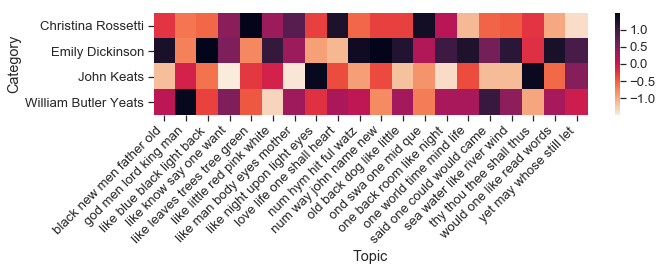

In [21]:
target_labels = ['John Keats', 'Emily Dickinson', 'William Butler Yeats', 'Christina Rossetti']

lmw.plot_categories_by_topics_heatmap(authors,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(10,4))

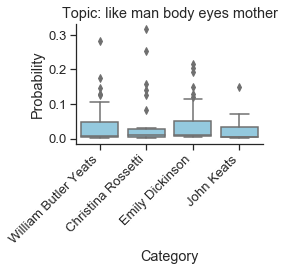

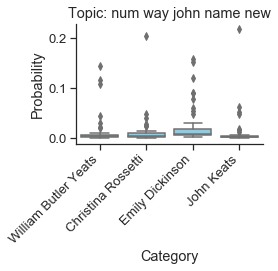

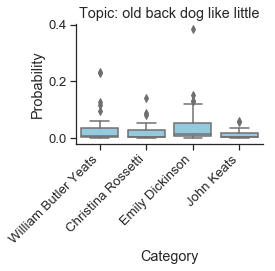

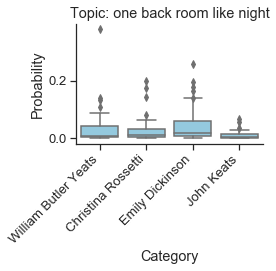

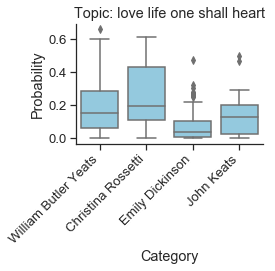

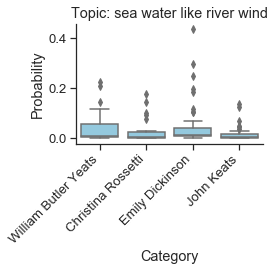

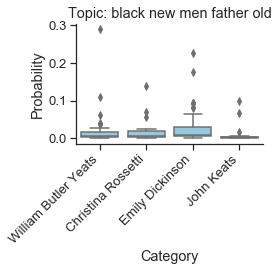

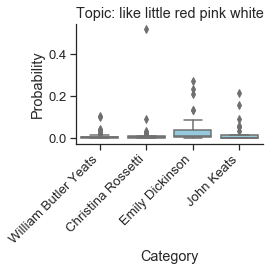

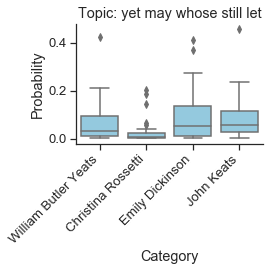

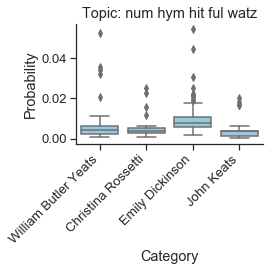

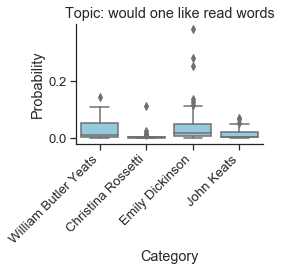

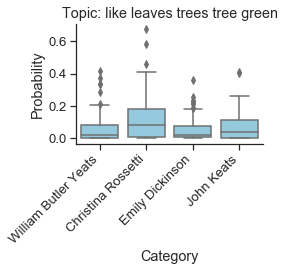

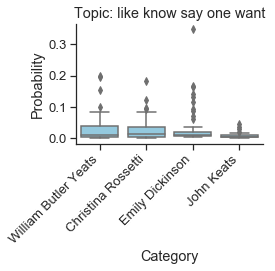

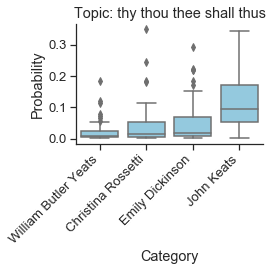

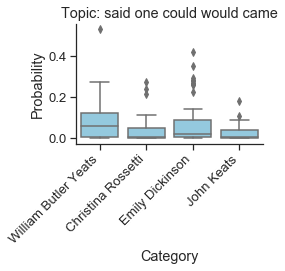

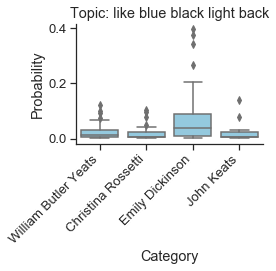

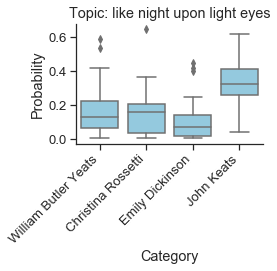

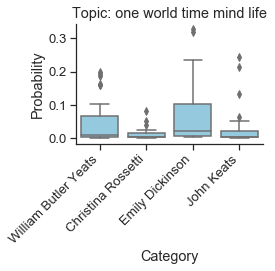

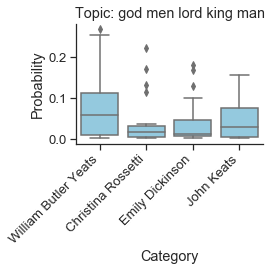

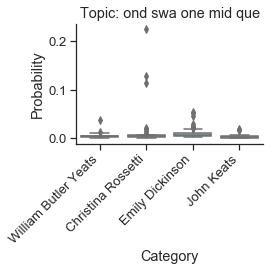

In [22]:
target_labels = ['John Keats', 'Emily Dickinson', 'William Butler Yeats', 'Christina Rossetti']

for _topic_index in range(0, len(topics)):
    
    lmw.plot_categories_by_topic_boxplots(authors,
                                          topic_distributions,
                                          topics, 
                                          _topic_index,
                                          output_path=output_directory_path + '/boxplot.' + str(_topic_index) + '.pdf',
                                          target_labels=target_labels,
                                          dim=(4,4))

<br><br>

# Plot topics over time

In [23]:
divided_documents, document_ids, times = lmw.divide_training_data(training_documents,
                                                                  num_chunks=10)

len(divided_documents), len(document_ids), len(times)

(156520, 156520, 156520)

In [24]:
new_training_data_path           = output_directory_path + '/training.split.txt'
new_formatted_training_data_path = output_directory_path + '/mallet.split.training'
new_topic_distributions_path     = output_directory_path + '/mallet.split.topic_distributions.' + str(num_topics)

In [25]:
lmw.infer_topics(MALLET_PATH,
                 formatted_training_data_path,
                 model_path,
                 new_training_data_path,
                 new_formatted_training_data_path,
                 new_topic_distributions_path,
                 divided_documents)
#                  [d for d in divided_documents if len(d) > 0])

Importing data...
Inferring topics using pre-trained model...


In [26]:
topic_distributions = lmw.load_topic_distributions(new_topic_distributions_path)

len(topic_distributions), len(topic_distributions[2])

(156520, 20)

In [27]:
for d in topic_distributions:
#     assert(len(d) == 20)
    if len(d) != 20:
        print('no')

no


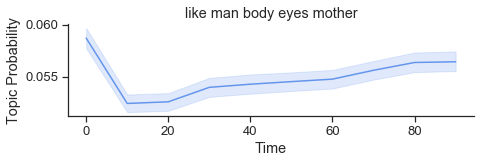

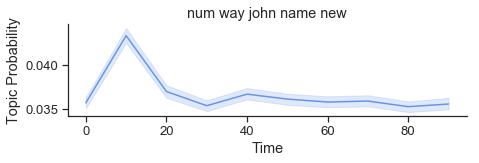

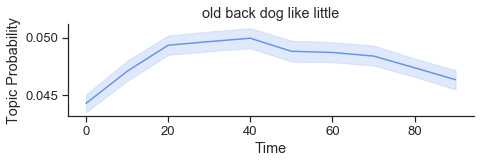

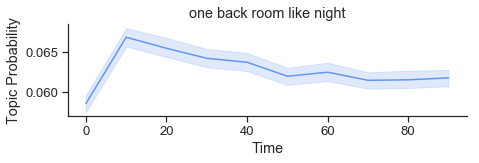

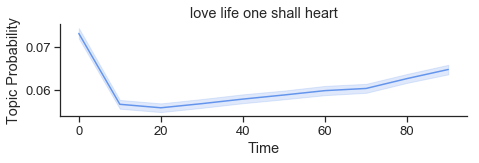

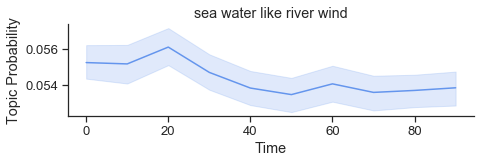

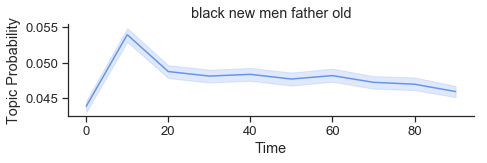

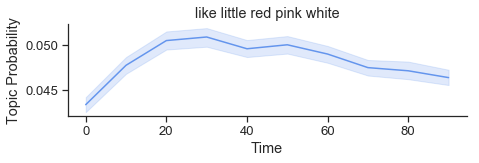

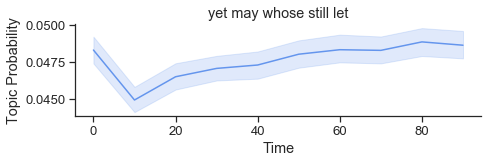

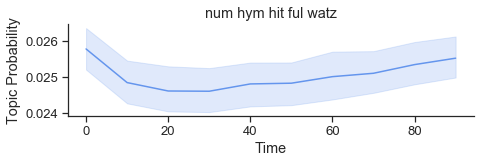

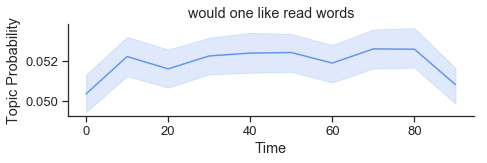

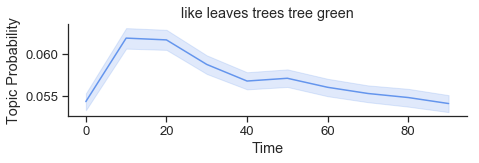

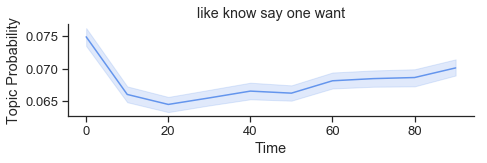

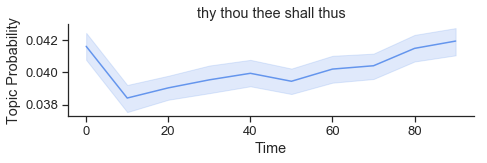

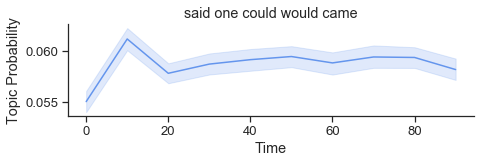

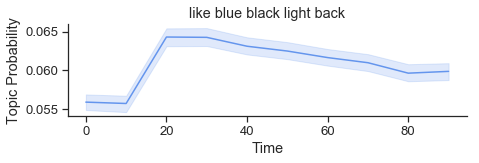

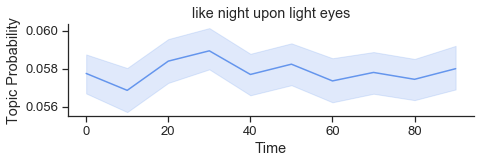

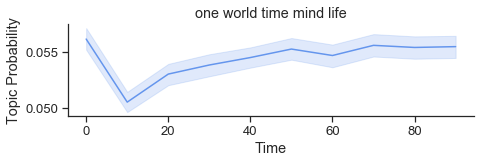

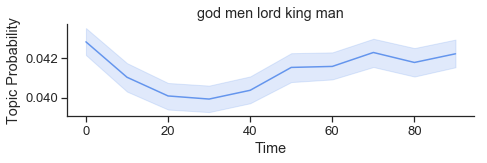

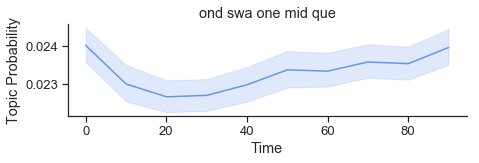

In [28]:
for _topic_index in range(0, len(topics)):
    lmw.plot_topics_over_time(topic_distributions, topics, times, _topic_index)